# Modular physics-based approach for lensless image reconstruction

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt


main_path = os.path.join("..")


metrics_dict = {
    "U20": "/home/bezzam/LenslessPiCam/outputs/2024-01-15/18-17-48",
    "U20(0db)": "/home/bezzam/LenslessPiCam/outputs/2024-01-15/18-11-05",
    "U20(10db)": "/home/bezzam/LenslessPiCam/outputs/2024-01-16/10-16-56",
    #
    "Unet+U20(0dB)": "/home/bezzam/LenslessPiCam/outputs/2024-01-16/08-37-01",
    #
    "U20+Drunet(res0.1)": "/home/bezzam/LenslessPiCam/outputs/2024-01-12/18-55-34",
    "Unet+U20+Drunet": "/home/bezzam/LenslessPiCam/outputs/2024-01-15/16-46-26",
    "Unet+U20+Drunet(res0.1)": "/home/bezzam/LenslessPiCam/outputs/2024-01-12/19-05-07",
}

Loading test dataset from configuration of one model (shouldn't be from noisy one).

Test set size: 999
Data shape: torch.Size([1, 135, 240, 3])
Data range: [0.01093662902712822, 0.28023838996887207]


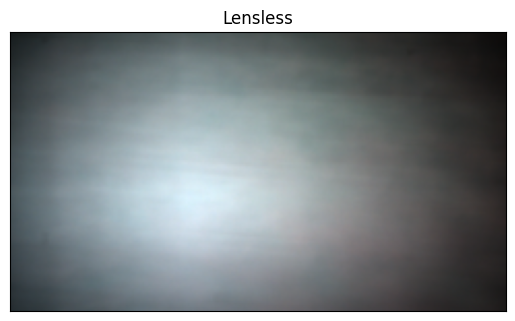

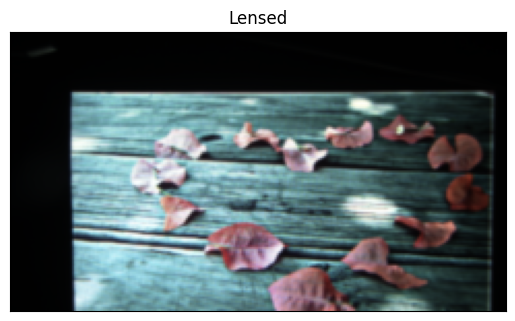

In [2]:
import yaml
from lensless.utils.dataset import DiffuserCamMirflickr
from torch.utils.data import Subset
from lensless.utils.plot import plot_image
import torch
from torchvision import transforms


device = "cuda:0"
model_path = os.path.join(metrics_dict["U20"])

# load Hydra config
config_path = os.path.join(model_path, ".hydra", "config.yaml")
with open(config_path, "r") as stream:
    config = yaml.safe_load(stream)

# load dataset
dataset = DiffuserCamMirflickr(
    dataset_dir=config["files"]["dataset"],
    psf_path=os.path.join(main_path, config["files"]["psf"]),
    downsample=config["files"]["downsample"],
)
test_indices = dataset.allowed_idx[dataset.allowed_idx <= 1000]
test_set = Subset(dataset, test_indices)
psf = dataset.psf.to(device)

print("Test set size:", len(test_set))

# plot one example
transform_vflip = transforms.Lambda(lambda x: torch.flip(x, dims=[-3]))
transform_BRG2RGB = transforms.Lambda(lambda x: x[..., [2, 1, 0]])

# -- define function as we always need to flip...
def plot_function(image, ax=None, color_correct=False):
    if color_correct:
        image = transform_BRG2RGB(image)
    image = transform_vflip(image)
    ax = plot_image(image.squeeze().cpu().numpy(), ax=ax)
    # remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
idx = 0
lensless, lensed = test_set[idx]
print(f"Data shape: {lensless.shape}")
print(f"Data range: [{lensless.min()}, {lensless.max()}]")
plot_function(lensless)
plt.title("Lensless")
plot_function(lensed)
plt.title("Lensed");

In [3]:
# utility to load a model
import torch
from lensless.recon.utils import create_process_network
from lensless.recon.unrolled_admm import UnrolledADMM


def load_model(model_path, device="cpu"):

    # load Hydra config
    config_path = os.path.join(model_path, ".hydra", "config.yaml")
    with open(config_path, "r") as stream:
        config = yaml.safe_load(stream)

    # load best model config
    model_checkpoint = os.path.join(model_path, "recon_epochBEST")
    assert os.path.exists(model_checkpoint), "Checkpoint does not exist"
    print("Loading checkpoint from : ", model_checkpoint)
    model_state_dict = torch.load(model_checkpoint, map_location=device)

    # load model
    pre_process = None
    post_process = None

    if config["reconstruction"]["pre_process"]["network"] is not None:

        pre_process, _ = create_process_network(
            network=config["reconstruction"]["pre_process"]["network"],
            depth=config["reconstruction"]["pre_process"]["depth"],
            nc=config["reconstruction"]["pre_process"]["nc"]
            if "nc" in config["reconstruction"]["pre_process"].keys()
            else None,
            device=device,
        )

    if config["reconstruction"]["post_process"]["network"] is not None:

        post_process, _ = create_process_network(
            network=config["reconstruction"]["post_process"]["network"],
            depth=config["reconstruction"]["post_process"]["depth"],
            nc=config["reconstruction"]["post_process"]["nc"]
            if "nc" in config["reconstruction"]["post_process"].keys()
            else None,
            device=device,
        )

    recon = UnrolledADMM(
        psf,
        pre_process=pre_process,
        post_process=post_process,
        n_iter=config["reconstruction"]["unrolled_admm"]["n_iter"],
        skip_unrolled=config["reconstruction"]["skip_unrolled"],
    )

    recon.load_state_dict(model_state_dict)

    return recon

# Motivating pre-processor

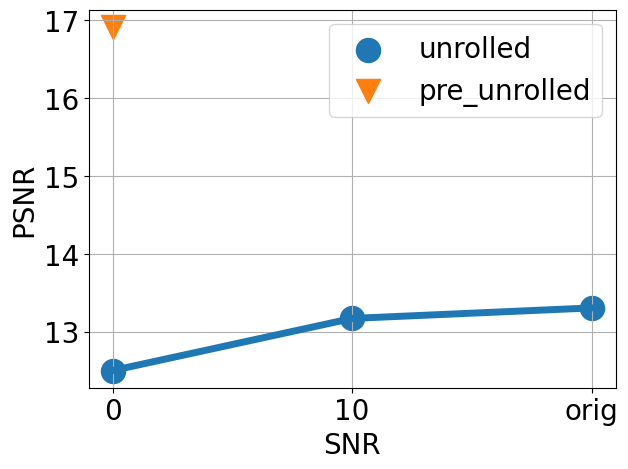

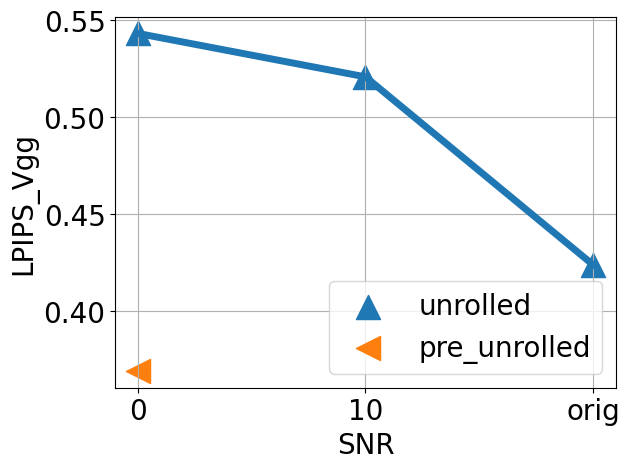

In [4]:
# pick models
exp1 = {
    "unrolled": {
        "0": metrics_dict["U20(0db)"],
        "10": metrics_dict["U20(10db)"],
        "orig": metrics_dict["U20"],
    },
    "pre_unrolled": {
        "0": metrics_dict["Unet+U20(0dB)"],
    },
}

# plot metrics as SNR varies
metrics = ["PSNR","LPIPS_Vgg"]
marker_size = 300
line_width = 5
text_size = 20

scatter_point = ["o", "v", "^", "<", ">", "s", "p", "P", "*", "h", "H", "+", "X", "D", "d", "|", "_"]

for metric in metrics:
    fig, ax1 = plt.subplots()
    for model in exp1:

        # extract
        vals = []
        for snr in exp1[model]:
            with open(os.path.join(exp1[model][snr], "metrics.json")) as f:
                metrics = json.load(f)
                vals.append(metrics[metric][metrics["best_epoch"]])
        # print(vals)
                
        # plot over SNR
        ax1.scatter(list(exp1[model].keys()), vals, label=model, marker=scatter_point.pop(0), s=marker_size)
        ax1.plot(list(exp1[model].keys()), vals, linewidth=line_width)

    ax1.set_xlabel("SNR", fontsize=text_size)
    ax1.set_ylabel(metric, fontsize=text_size)
    # set tick size
    ax1.tick_params(axis='both', which='major', labelsize=text_size)
    ax1.legend(fontsize=text_size)
    ax1.grid(True)

    # save
    plt.tight_layout()
    plt.savefig(os.path.join("modular", "exp1_{}.png".format(metric)))

# Residual connection

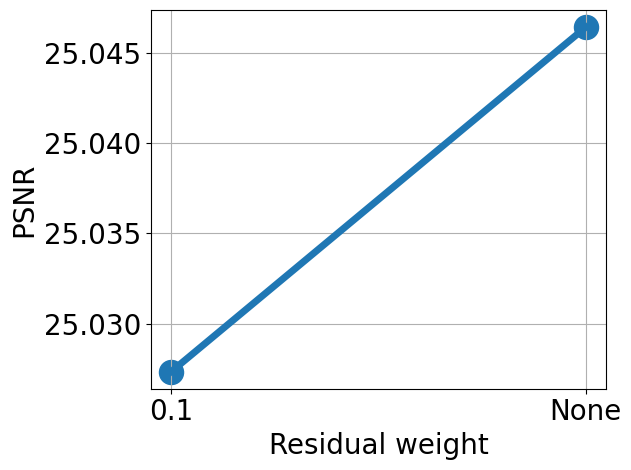

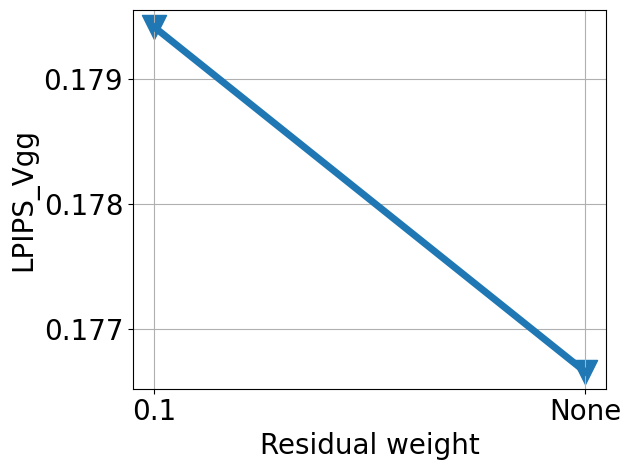

In [5]:
# pick models
exp2 = {
    "0.1": metrics_dict["Unet+U20+Drunet(res0.1)"],
    "None": metrics_dict["Unet+U20+Drunet"],
}

# plot as residual weight varies
metrics = ["PSNR","LPIPS_Vgg"]
marker_size = 300
line_width = 5
text_size = 20

scatter_point = ["o", "v", "^", "<", ">", "s", "p", "P", "*", "h", "H", "+", "X", "D", "d", "|", "_"]

for metric in metrics:
    fig, ax1 = plt.subplots()
    vals = []
    for res_weight in exp2:

        # extract metrics
        with open(os.path.join(exp2[res_weight], "metrics.json")) as f:
            metrics = json.load(f)
            vals.append(metrics[metric][metrics["best_epoch"]])
    # print(vals)
                
    # plot over residual weight
    ax1.scatter(list(exp2.keys()), vals, marker=scatter_point.pop(0), s=marker_size)
    ax1.plot(list(exp2.keys()), vals, linewidth=line_width)

    ax1.set_xlabel("Residual weight", fontsize=text_size)
    ax1.set_ylabel(metric, fontsize=text_size)
    # set tick size
    ax1.tick_params(axis='both', which='major', labelsize=text_size)
    ax1.grid(True)

    # save
    plt.tight_layout()
    plt.savefig(os.path.join("modular", "exp2_{}.png".format(metric)))

Very little deterioration of the image quality.

Compare intermediate results

In [6]:
# load models
exp2_models = {}
for model in exp2:
    print(exp2[model])
    exp2_models[model] = load_model(exp2[model], device=device)

/home/bezzam/LenslessPiCam/outputs/2024-01-12/19-05-07
Loading checkpoint from :  /home/bezzam/LenslessPiCam/outputs/2024-01-12/19-05-07/recon_epochBEST


/home/bezzam/LenslessPiCam/outputs/2024-01-15/16-46-26
Loading checkpoint from :  /home/bezzam/LenslessPiCam/outputs/2024-01-15/16-46-26/recon_epochBEST


Residual weight: 0.1


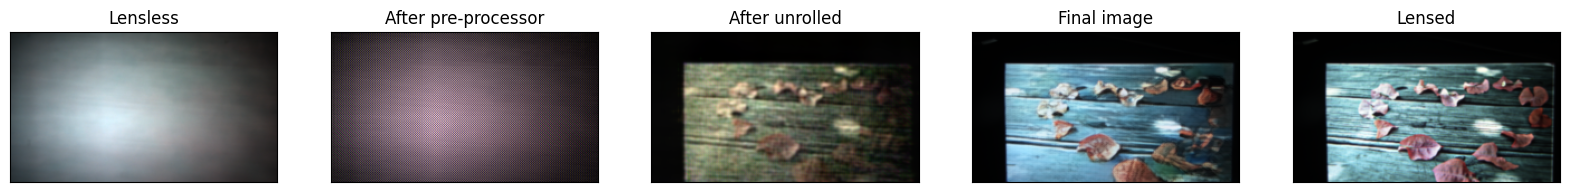

Residual weight: None


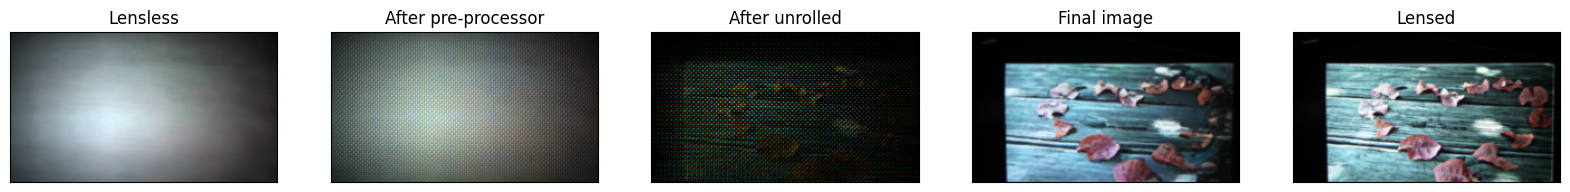

In [7]:
# plot reconstructions
idx = 0

# get data
lensless, lensed = test_set[idx]

# apply
for res_weight in exp2_models:
    print(f"Residual weight: {res_weight}")

    _model = exp2_models[res_weight]

    with torch.no_grad():
        _model.set_data(lensless.unsqueeze(0).to(device))
        final, pre, pre_post = _model.apply(
            plot=False,
            save=False,
            output_intermediate=True,
        )

    # color correction
    transform_BRG2RGB = transforms.Lambda(lambda x: x[..., [2, 1, 0]])

    # plot 4 images in one row
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    plot_function(lensless, ax=axs[0])
    axs[0].set_title("Lensless")
    plot_function(pre, ax=axs[1], color_correct=True)
    axs[1].set_title("After pre-processor")
    plot_function(pre_post, ax=axs[2], color_correct=True)
    axs[2].set_title("After unrolled")
    plot_function(final, ax=axs[3])
    axs[3].set_title("Final image")
    plot_function(lensed, ax=axs[4])
    axs[4].set_title("Lensed")
    plt.show()
    

More interpretable with residual connection!

# Full benchmark

Max PSNR for U20 (epoch 11): 13.49551833152771
Max PSNR for U20(0db) (epoch 10): 12.745057544708253
Max PSNR for U20(10db) (epoch 7): 13.174690866470337
Max PSNR for Unet+U20(0dB) (epoch 10): 17.64387469291687
Max PSNR for U20+Drunet(res0.1) (epoch 50): 23.68380319595337
Max PSNR for Unet+U20+Drunet (epoch 19): 25.061270294189452
Max PSNR for Unet+U20+Drunet(res0.1) (epoch 50): 25.169003791809082
Min LPIPS_Vgg for U20 (epoch 21): 0.423706456720829
Min LPIPS_Vgg for U20(0db) (epoch 14): 0.5416195911169052
Min LPIPS_Vgg for U20(10db) (epoch 10): 0.5205210560560226
Min LPIPS_Vgg for Unet+U20(0dB) (epoch 19): 0.3652945226430893
Min LPIPS_Vgg for U20+Drunet(res0.1) (epoch 17): 0.20415819093585014
Min LPIPS_Vgg for Unet+U20+Drunet (epoch 23): 0.1763310904800892
Min LPIPS_Vgg for Unet+U20+Drunet(res0.1) (epoch 42): 0.17877371072769166
Max SSIM for U20 (epoch 11): 0.5365034118294716
Max SSIM for U20(0db) (epoch 10): 0.36297357857227325
Max SSIM for U20(10db) (epoch 10): 0.4172427293658256
Max 

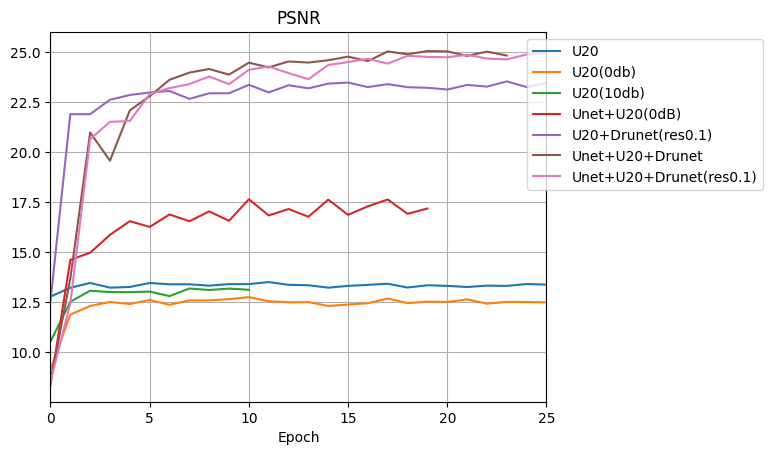

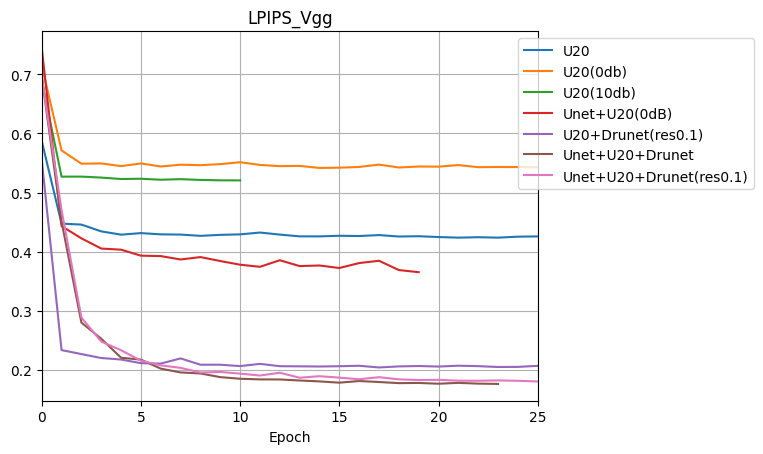

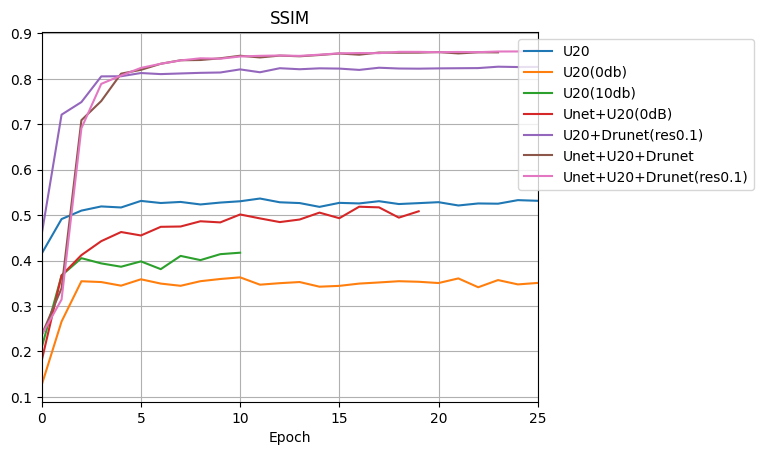

In [8]:
# metrics: 'LOSS', 'MSE', 'MAE', 'LPIPS_Vgg', 'LPIPS_Alex', 'PSNR', 'SSIM', 'ReconstructionError'

plot_metrics = ["PSNR", "LPIPS_Vgg", "SSIM"]
MAX_EPOCH = 25

for metric in plot_metrics:
    plt.figure()
    for key, value in metrics_dict.items():
        _metrics_path = os.path.join(value, "metrics.json")
        assert os.path.exists(_metrics_path), f"Path {_metrics_path} does not exist"
        _test_metrics = json.load(open(_metrics_path))

        _test_metrics = np.array(_test_metrics[metric])
        plt.plot(_test_metrics, label=key)

        if metric == "PSNR" or metric == "SSIM":
            print(f"Max {metric} for {key} (epoch {np.argmax(_test_metrics)}): {np.max(_test_metrics)}")
        else:
            print(f"Min {metric} for {key} (epoch {np.argmin(_test_metrics)}): {np.min(_test_metrics)}")

    plt.xlabel("Epoch")
    plt.title(metric)
    plt.grid()
    plt.xlim(0, MAX_EPOCH)
    plt.legend(loc="upper right", bbox_to_anchor=(1.45, 1.0))




-- U20 --
Best epoch for U20: 23 / 25
Best test loss for U20: 0.47213489985093476
PSNR: 13.305209789276123
SSIM: 0.5251176372170449
LPIPS_Vgg: 0.4237117138504982

-- U20(0db) --
Best epoch for U20(0db): 25 / 25
Best test loss for U20(0db): 0.6014221708290279
PSNR: 12.482326955795289
SSIM: 0.3506945177912712
LPIPS_Vgg: 0.5426787078380585

-- U20(10db) --
Best epoch for U20(10db): 9 / 10
Best test loss for U20(10db): 0.5708882611617446
PSNR: 13.170289192199707
SSIM: 0.41400049179792403
LPIPS_Vgg: 0.5206502535939217

-- Unet+U20(0dB) --
Best epoch for Unet+U20(0dB): 19 / 19
Best test loss for Unet+U20(0dB): 0.38489538893103603
PSNR: 17.179627723693848
SSIM: 0.5084027940034866
LPIPS_Vgg: 0.3652945226430893

-- U20+Drunet(res0.1) --
Best epoch for U20+Drunet(res0.1): 17 / 25
Best test loss for U20+Drunet(res0.1): 0.20882477592211215
PSNR: 23.4050510597229
SSIM: 0.8244372725486755
LPIPS_Vgg: 0.20415819093585014

-- Unet+U20+Drunet --
Best epoch for Unet+U20+Drunet: 23 / 23
Best test loss fo

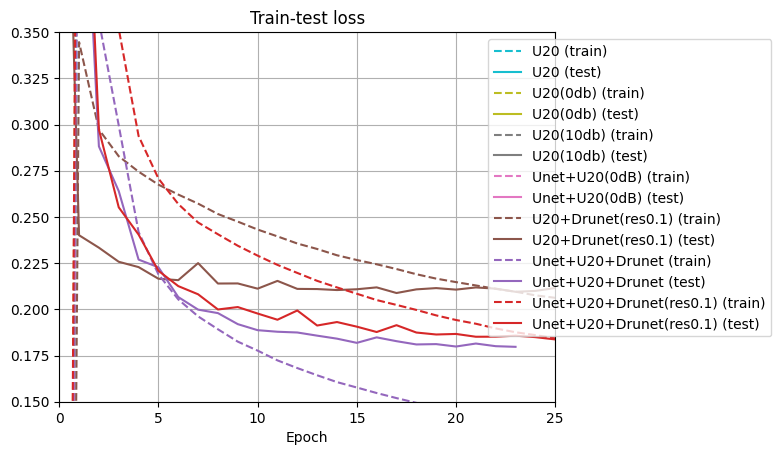

In [9]:
MAX_EPOCH = 25

# plot train and test loss
import matplotlib.colors as mcolors
plot_colors = list(mcolors.TABLEAU_COLORS.keys())
# plot_colors = ["b", "g", "r", "c", "m", "y", "k"]
plt.figure()
for key, value in metrics_dict.items():
    _metrics_path = os.path.join(value, "metrics.json")
    assert os.path.exists(_metrics_path), f"Path {_metrics_path} does not exist"
    _test_metrics = json.load(open(_metrics_path))

    color = plot_colors.pop()
    train_loss = np.array(_test_metrics["LOSS"])
    train_loss = train_loss[:MAX_EPOCH+1]
    plt.plot(train_loss, label=key + " (train)", color=color, linestyle="--")

    test_loss = np.array(_test_metrics["MSE"]) + np.array(_test_metrics["LPIPS_Vgg"])
    test_loss = test_loss[:MAX_EPOCH+1]
    plt.plot(test_loss, label=key + " (test)", linestyle="-", color=color)

    best_epoch = np.argmin(test_loss)
    print(f"\n-- {key} --")
    print(f"Best epoch for {key}: {best_epoch} / {len(test_loss)-1}")
    print(f"Best test loss for {key}: {test_loss[best_epoch]}")
    # print metrics
    print(f"PSNR: {np.array(_test_metrics['PSNR'])[best_epoch]}")
    print(f"SSIM: {np.array(_test_metrics['SSIM'])[best_epoch]}")
    print(f"LPIPS_Vgg: {np.array(_test_metrics['LPIPS_Vgg'])[best_epoch]}")

plt.xlabel("Epoch")
plt.title("Train-test loss")

#legend outside
plt.legend(loc="upper right", bbox_to_anchor=(1.45, 1.0))
plt.ylim([0.15, 0.35]);
plt.xlim([0, MAX_EPOCH]);

plt.grid()


# plot intermediate outputs

Loading checkpoint from :  /home/bezzam/LenslessPiCam/outputs/2024-01-12/18-55-34/recon_epochBEST


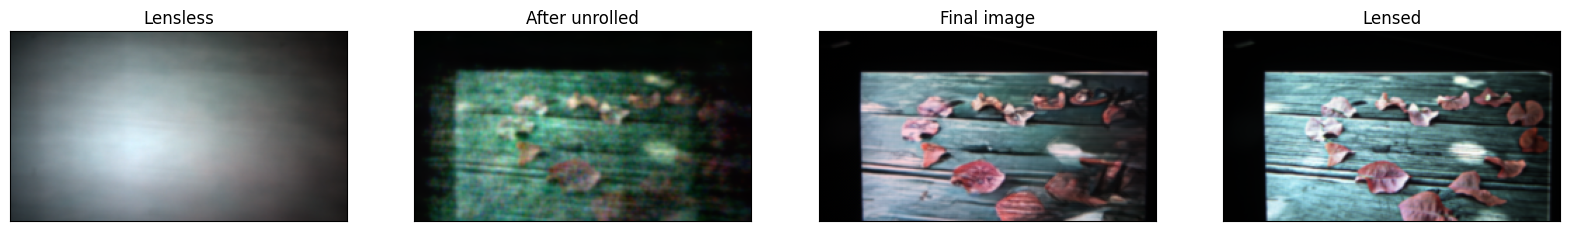

In [10]:
model = "U20+Drunet(res0.1)"
# model = "Unet+U20+Drunet(res0.1)"
# model = "U20"
idx = 0

# get data
lensless, lensed = test_set[idx]

# load model
recon = load_model(metrics_dict[model], device=device)

# apply
with torch.no_grad():
    recon.set_data(lensless.unsqueeze(0).to(device))
    final, pre, pre_post = recon.apply(
        plot=False,
        save=False,
        output_intermediate=True,
    )

# plot
if pre is not None:
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
elif pre_post is not None:
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
else:
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

plot_function(lensless, ax=axs[0])
axs[0].set_title("Lensless")
if pre is not None:
    plot_function(pre, ax=axs[1], color_correct=True)
    axs[1].set_title("After pre-processor")
    plot_function(pre_post, ax=axs[2], color_correct=True)
    axs[2].set_title("After unrolled")
    plot_function(final, ax=axs[3])
    axs[3].set_title("Final image")
    plot_function(lensed, ax=axs[4])
    axs[4].set_title("Lensed")
elif pre_post is not None:
    plot_function(pre_post, ax=axs[1])
    axs[1].set_title("After unrolled")
    plot_function(final, ax=axs[2])
    axs[2].set_title("Final image")
    plot_function(lensed, ax=axs[3])
    axs[3].set_title("Lensed")
else:
    plot_function(final, ax=axs[1])
    axs[1].set_title("Final image")
    plot_function(lensed, ax=axs[2])
    axs[2].set_title("Lensed")
plt.show()
